In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('ch6_cell28_dev_feat1_filtered.tsv.gz', compression='gzip', sep='\t')

In [3]:
df.head(5)

,name,rel#count,http://dbpedia.org/ontology/area#1,http://dbpedia.org/ontology/areaCode#count,http://dbpedia.org/ontology/areaLand#count,http://dbpedia.org/ontology/areaLand#1,http://dbpedia.org/ontology/areaLand#2,http://dbpedia.org/ontology/areaTotal#count,http://dbpedia.org/ontology/areaTotal#1,http://dbpedia.org/ontology/areaWater#count,...,http://www.w3.org/2000/01/rdf-schema#seeAlso#3@<http://dbpedia.org/resource/History_of_Hamburg>,http://www.w3.org/2000/01/rdf-schema#seeAlso#3@<http://dbpedia.org/resource/List_of_people_from_Bolton>,http://www.w3.org/2000/01/rdf-schema#seeAlso#3@<http://dbpedia.org/resource/List_of_educational_institutions>,http://www.w3.org/2000/01/rdf-schema#seeAlso#3@<http://dbpedia.org/resource/History_of_local_government>,http://www.w3.org/2000/01/rdf-schema#seeAlso#3@<http://dbpedia.org/resource/Hainan>,http://www.w3.org/2000/01/rdf-schema#seeAlso#3@OTHER,http://xmlns.com/foaf/0.1/homepage#count,http://xmlns.com/foaf/0.1/name#count,http://xmlns.com/foaf/0.1/nick#count,population
0,<http://dbpedia.org/resource/Ankara>,2.856124,0.0,0.30103,0.000000,0.0,0.000000e+00,0.301030,2.452100e+10,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.477121,0.30103,0.30103,6.661582
1,<http://dbpedia.org/resource/Amsterdam>,3.358316,0.0,0.30103,0.301030,165760000.0,0.000000e+00,0.301030,2.193200e+08,0.301030,...,0.0,0.0,0.0,0.0,0.0,1.0,0.301030,0.30103,0.30103,5.925489
2,<http://dbpedia.org/resource/Aarhus>,2.561101,0.0,0.30103,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.301030,0.30103,0.00000,5.422780
3,<http://dbpedia.org/resource/Adelaide>,2.955207,0.0,0.00000,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.30103,0.00000,6.119513
4,"<http://dbpedia.org/resource/Ames,_Iowa>",2.082785,0.0,0.00000,0.477121,62700000.0,6.270361e+07,0.477121,6.286000e+07,0.477121,...,0.0,0.0,0.0,0.0,0.0,1.0,0.301030,0.30103,0.00000,4.770594


### Feature Importances

In [4]:
# create a random forest regressor
rf = RandomForestRegressor(n_estimators=10,
                           min_samples_leaf=1,
                           n_jobs=-1)

In [5]:
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

X['random'] = np.random.random(size=len(X))

In [6]:
rf = rf.fit(X, y)

In [7]:
columns = np.array(X.columns)

top_features = list(np.argsort(rf.feature_importances_)[-11:])[-1: 0: -1]
top_features_val = list(np.sort(rf.feature_importances_)[-11:])[-1: 0: -1]

feature_names = columns[top_features]

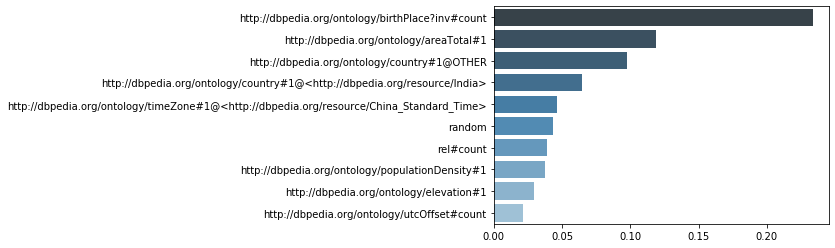

In [9]:
import seaborn as sns
chart = sns.barplot(top_features_val, feature_names, orient='h', palette='Blues_d')

The chart above shows that <font color='red'>'random'</font> feature stands at rank 6. The results show that <font color='red'>'random'</font> feature is more predictive of the output than <font color='red'>'populationDensity#1'</font>, <font color='red'>'rel#count'</font>, <font color='red'>'elevation#1'</font>, and <font color='red'>utcOffset#count</font> which doesn't make sense. So, we can understand that there might be something wrong with the results.

### Drop column importance

Because of strange results of previous step, I decided to perform a drop-column importance to get the most important features of the dataset on a portion of the dataset (0.2 of dataset) to decrease training time.

In [11]:
from IPython.display import clear_output
from sklearn.base import clone

X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

scores = np.empty(shape=(0,1))

rf_ = clone(rf)
rf_.random_state = 999
rf_ = rf_.fit(X_train, y_train)
base_score = rf_.score(X_train, y_train)
print('model base score: ' + str(base_score))


for i in range(len(X_train.columns)):
    X_dropped = X_train.drop(X_train.columns[i], axis=1)

    rf_ = clone(rf)
    rf_.random_state = 999
    rf_ = rf_.fit(X_dropped, y_train)
    dropped_score = rf_.score(X_dropped, y_train)
    
    importance = np.array([[base_score - dropped_score]])
    scores = np.append(scores, importance, axis=0)
    
    clear_output(wait=True)
    print('feature#' + str(i))
    print('feature name: ' + columns[i])
    print('model score: ' + str(dropped_score))

feature#378
feature name: http://xmlns.com/foaf/0.1/nick#count
model score: 0.9449727260992956


In [12]:
df_imp = pd.DataFrame({'Feature': X_train.columns, 
                       'Importance': list(scores.reshape(len(scores),))})

df_imp

,Feature,Importance
0,rel#count,0.000542
1,http://dbpedia.org/ontology/area#1,0.000088
2,http://dbpedia.org/ontology/areaCode#count,0.000635
3,http://dbpedia.org/ontology/areaLand#count,-0.000260
4,http://dbpedia.org/ontology/areaLand#1,-0.000009
...,...,...
374,http://www.w3.org/2000/01/rdf-schema#seeAlso#3...,0.000185
375,http://www.w3.org/2000/01/rdf-schema#seeAlso#3...,0.000001
376,http://xmlns.com/foaf/0.1/homepage#count,-0.000011
377,http://xmlns.com/foaf/0.1/name#count,0.000287


In [13]:
df_top_features = df_imp.sort_values(by='Importance', ascending=False).head(10)

df_top_features

,Feature,Importance
133,http://dbpedia.org/ontology/populationDensity#1,0.005508
7,http://dbpedia.org/ontology/areaTotal#1,0.004504
96,http://dbpedia.org/ontology/elevation#1,0.003516
102,http://dbpedia.org/ontology/isPartOf?inv#count,0.000670
33,http://dbpedia.org/ontology/country#1@OTHER,0.000666
2,http://dbpedia.org/ontology/areaCode#count,0.000635
0,rel#count,0.000542
11,http://dbpedia.org/ontology/city?inv#count,0.000501
140,http://dbpedia.org/ontology/region#1@<http://d...,0.000489
355,http://www.w3.org/2000/01/rdf-schema#seeAlso#3...,0.000450


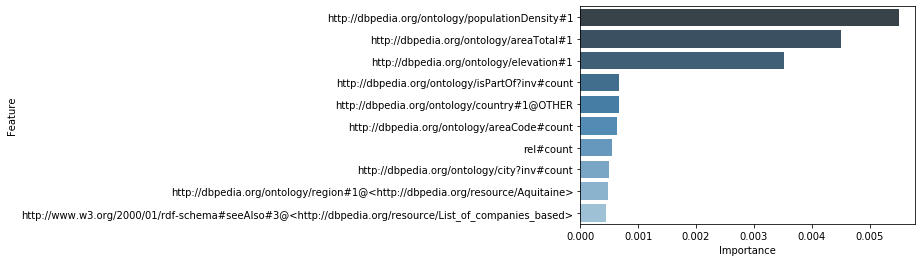

In [14]:
chart = sns.barplot(df_top_features['Importance'], df_top_features['Feature'], orient='h', palette='Blues_d')

We see that 'populationDensity#1' seems to be the most important feature in the dataset to predict population. So, we select to continue with this feature.

In [15]:
F = 'http://dbpedia.org/ontology/populationDensity#1'

### Train model using the original data [without random] and get MSE value

In [150]:
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

In [146]:
rf = rf.fit(X, y)

In [149]:
base_model_score = (100 * rf.score(X, y))
print('Model Score - base model: %2.3f' % (base_model_score))

Model Score - base model: 94.689


### Generate F' feature

In [152]:
F_prime = F + '_prime'

df_copy = df.copy()

df_copy[F_prime] = df_copy[F]
df_copy.loc[df_copy[F] >= df_copy[F].mean(), F_prime] = 1
df_copy.loc[df_copy[F] <  df_copy[F].mean(), F_prime] = 0

print(len(df_copy.loc[df_copy[F_prime] == 1]))
print(len(df_copy.loc[df_copy[F_prime] == 0]))

8042
36917


### Train and evaluate model with F' feature included as an additional feature

In [153]:
columns = list(df_copy.columns)

X = df_copy[columns[1:-2] + columns[-1:]]
y = df_copy.loc[:,'population']

In [156]:
rf = rf.fit(X, y)

In [157]:
fprime_added_model_score = (100 * rf.score(X, y))
print('Model Score - F\' added: %2.3f' % (fprime_added_model_score))

Model Score - F' added: 94.661


### Train and evalute model with F' feature replaced with F feature

In [158]:
if (F_prime in df_copy.columns):
    df_copy[F] = df_copy[F_prime]
    df_copy.drop(F_prime, inplace=True, axis=1)
    
columns = list(df_copy.columns)

X = df_copy[columns[1:-1]]
y = df_copy[columns[-1]]

In [159]:
rf = rf.fit(X, y)

In [160]:
fprime_replaced_model_score = (100 * rf.score(X, y))
print('Model Score - F\' replaced: %2.3f' % (fprime_replaced_model_score))

Model Score - F' replaced: 94.308


### Compare model scores

In [161]:
print('Model Score - base model: %2.3f' % (base_model_score))
print('Model Score - F\' added: %2.3f' % (fprime_added_model_score))
print('Model Score - F\' replaced: %2.3f' % (fprime_replaced_model_score))

Model Score - base model: 94.689
Model Score - F' added: 94.661
Model Score - F' replaced: 94.308
